In [16]:
import numpy as np
import pandas as pd
import os
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import joblib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input


In [17]:
# Konfigurasi
DATASET_PATH = "/kaggle/input/datasetsegmen/FrameSeg5000/FrameSeg5000"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
FINE_TUNE_AT = 150

In [18]:
# List semua folder (label)
class_names = sorted([folder for folder in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, folder))])
print("Label Kelas:", class_names)

# Buat mapping label ke index numerik
label_to_index = {label: idx for idx, label in enumerate(class_names)}
print("Mapping Label ke Index:", label_to_index)

# Load gambar dan beri label
data = []
labels = []

for label in class_names:
    folder_path = os.path.join(DATASET_PATH, label)
    for img_file in os.listdir(folder_path):
        if img_file.lower().endswith(('.jpg', '.png')):
            img_path = os.path.join(folder_path, img_file)
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img = img_to_array(img)
            img = preprocess_input(img)  # ⬅️ perbaikan penting di sini
            data.append(img)
            labels.append(label_to_index[label])

# Ubah ke numpy array
data = np.array(data, dtype='float32')
labels = np.array(labels)

# Ubah label ke one-hot
labels_categorical = to_categorical(labels, num_classes=len(class_names))

Label Kelas: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Mapping Label ke Index: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [19]:
# Train:Val:Test = 70:20:10
X_temp, X_test, y_temp, y_test = train_test_split(data, labels, test_size=0.1, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2222, stratify=y_temp, random_state=42)

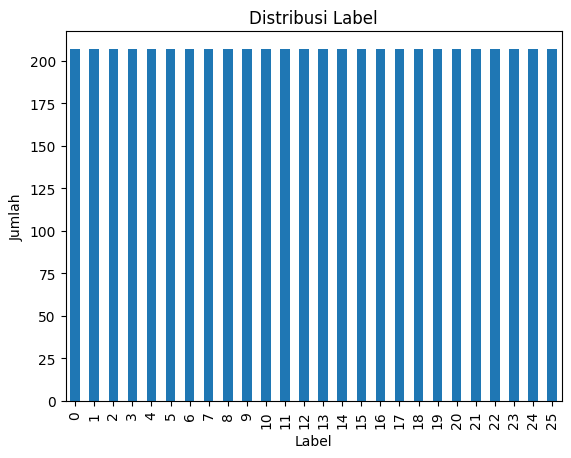

In [20]:
# Jumlah gambar per kelas
label_counts = pd.Series(labels).value_counts().sort_index()
label_counts.plot(kind='bar')
plt.title("Distribusi Label")
plt.xlabel("Label")
plt.ylabel("Jumlah")
plt.show()


In [21]:
# 🛑 Callback: EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',        # atau 'val_accuracy', tergantung preferensimu
    patience=7,                # jumlah epoch tanpa peningkatan sebelum stop
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

In [22]:
# 💡 One-hot encode label
y_train = to_categorical(y_train, num_classes=len(class_names))
y_val = to_categorical(y_val, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

# 📦 Load pre-trained base model
base_model = MobileNetV3Small(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                              include_top=False,
                              weights='imagenet')
base_model.trainable = False  # Freeze dulu untuk pretraining

# 🔧 Tambahkan custom top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(class_names), activation='softmax')(x)


# 🔨 Buat model akhir
model = Model(inputs=base_model.input, outputs=predictions)

# 🟢 Kompilasi untuk pretraining
model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"🔍 Learning Rate (Pretraining): {model.optimizer.learning_rate.numpy()}")
print("🔧 Pretraining top layers...")
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=5,
          batch_size=BATCH_SIZE)

# 🔁 Fine-tuning (unfreeze sebagian base_model)
base_model.trainable = True
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

# 🔵 Kompilasi ulang dengan LR lebih kecil
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(f"🔍 Learning Rate (Fine-Tuning): {model.optimizer.learning_rate.numpy()}")
print("🔧 Fine-tuning model...")
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stop])

🔍 Learning Rate (Pretraining): 0.009999999776482582
🔧 Pretraining top layers...
Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.1701 - loss: 2.9119 - val_accuracy: 0.7679 - val_loss: 0.9875
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5981 - loss: 1.2128 - val_accuracy: 0.8338 - val_loss: 0.5048
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7452 - loss: 0.7212 - val_accuracy: 0.9146 - val_loss: 0.2751
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7886 - loss: 0.6036 - val_accuracy: 0.9313 - val_loss: 0.2658
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8219 - loss: 0.5043 - val_accuracy: 0.9322 - val_loss: 0.1877
🔍 Learning Rate (Fine-Tuning): 0.0010000000474974513
🔧 Fine-tuning model...
Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 30s 140ms/step - accuracy: 0.8472 - loss: 0.4699 - val_accuracy: 0.8384 - val_loss: 0.4891
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9102

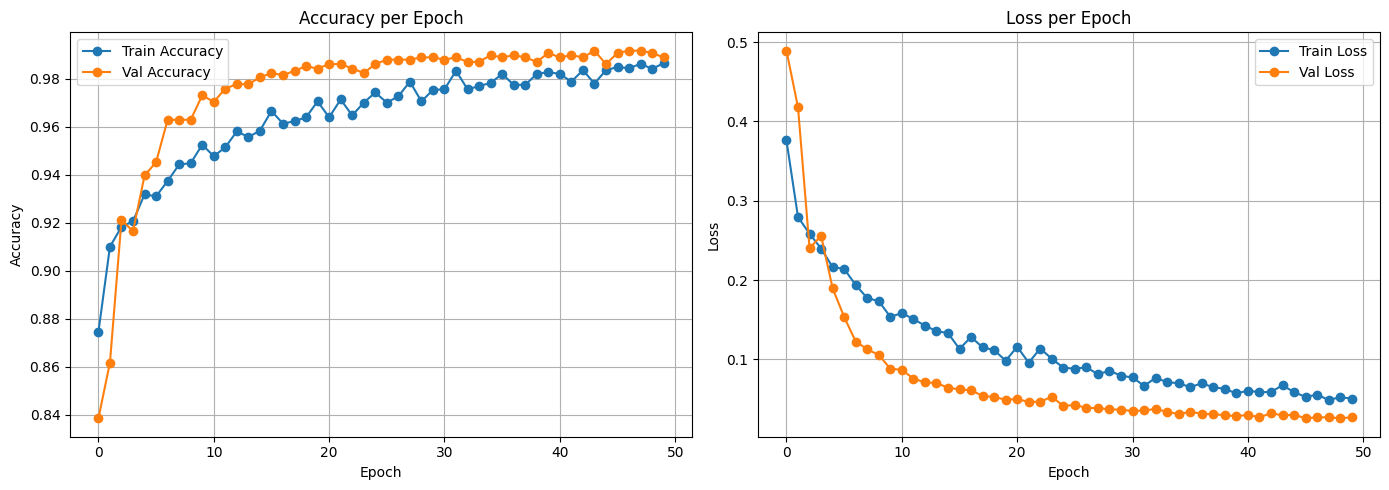

In [23]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step


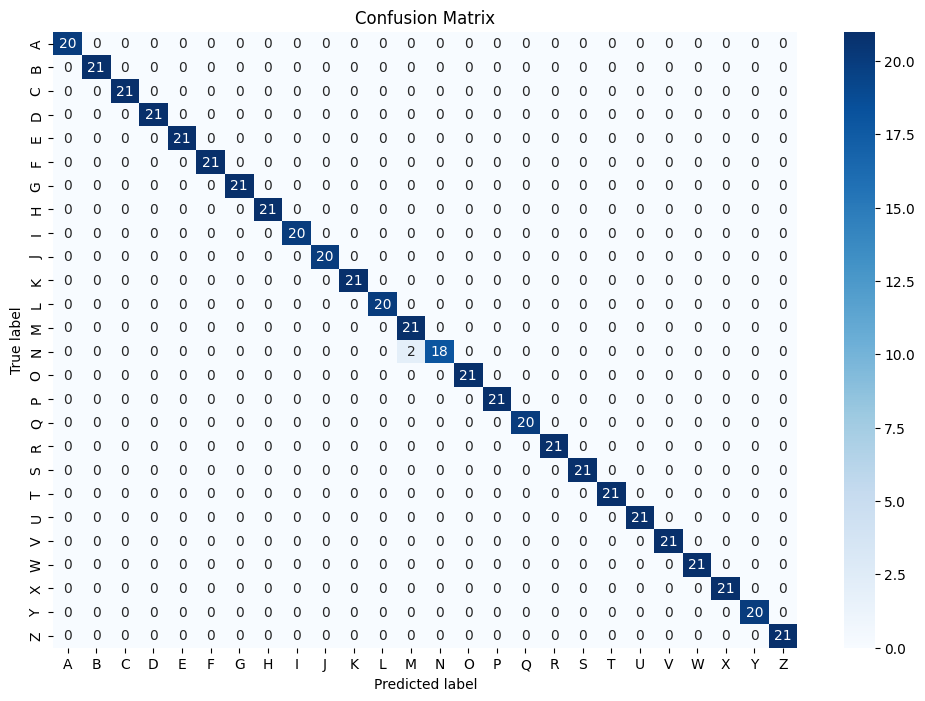

=== Overall Metrics ===
Accuracy : 0.9963
Precision: 0.9966
Recall   : 0.9963
F1-score : 0.9963

=== Classification Report ===
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        20
           B       1.00      1.00      1.00        21
           C       1.00      1.00      1.00        21
           D       1.00      1.00      1.00        21
           E       1.00      1.00      1.00        21
           F       1.00      1.00      1.00        21
           G       1.00      1.00      1.00        21
           H       1.00      1.00      1.00        21
           I       1.00      1.00      1.00        20
           J       1.00      1.00      1.00        20
           K       1.00      1.00      1.00        21
           L       1.00      1.00      1.00        20
           M       0.91      1.00      0.95        21
           N       1.00      0.90      0.95        20
           O       1.00      1.00      1.00        21
        

In [24]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(X_test, batch_size=BATCH_SIZE), axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("=== Overall Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}\n")

print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


In [25]:
import tensorflow as tf
import joblib

# Simpan dalam format HDF5 (.h5)
model.save("/kaggle/working/mobilenetv3.h5")

# Simpan dalam format Keras v3 (.keras)
model.save("/kaggle/working/mobilenetv3.keras")

# Konversi ke format TensorFlow Lite (.tflite)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("/kaggle/working/mobilenetv3.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan fitur model ke .pkl
features = model.predict(X_train)
joblib.dump(features, "/kaggle/working/mobilenetv3.pkl")

print("✅ Model berhasil disimpan dalam format .h5, .keras, .tflite dan fitur dalam .pkl")


Saved artifact at '/tmp/tmp4yf31q6p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_556')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  137469099987536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468224750608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468224751184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137469099987152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468224751376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468224752720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468224753104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468224753488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468224753296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468224750224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468224

W0000 00:00:1752110844.939582      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752110844.939612      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
✅ Model berhasil disimpan dalam format .h5, .keras, .tflite dan fitur dalam .pkl


In [26]:
import json

# Simpan label map ke file
label_map = {str(i): label for i, label in enumerate(class_names)}

with open("/kaggle/working/label_map.json", "w") as f:
    json.dump(label_map, f)

print("✅ label_map.json berhasil disimpan.")


✅ label_map.json berhasil disimpan.


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


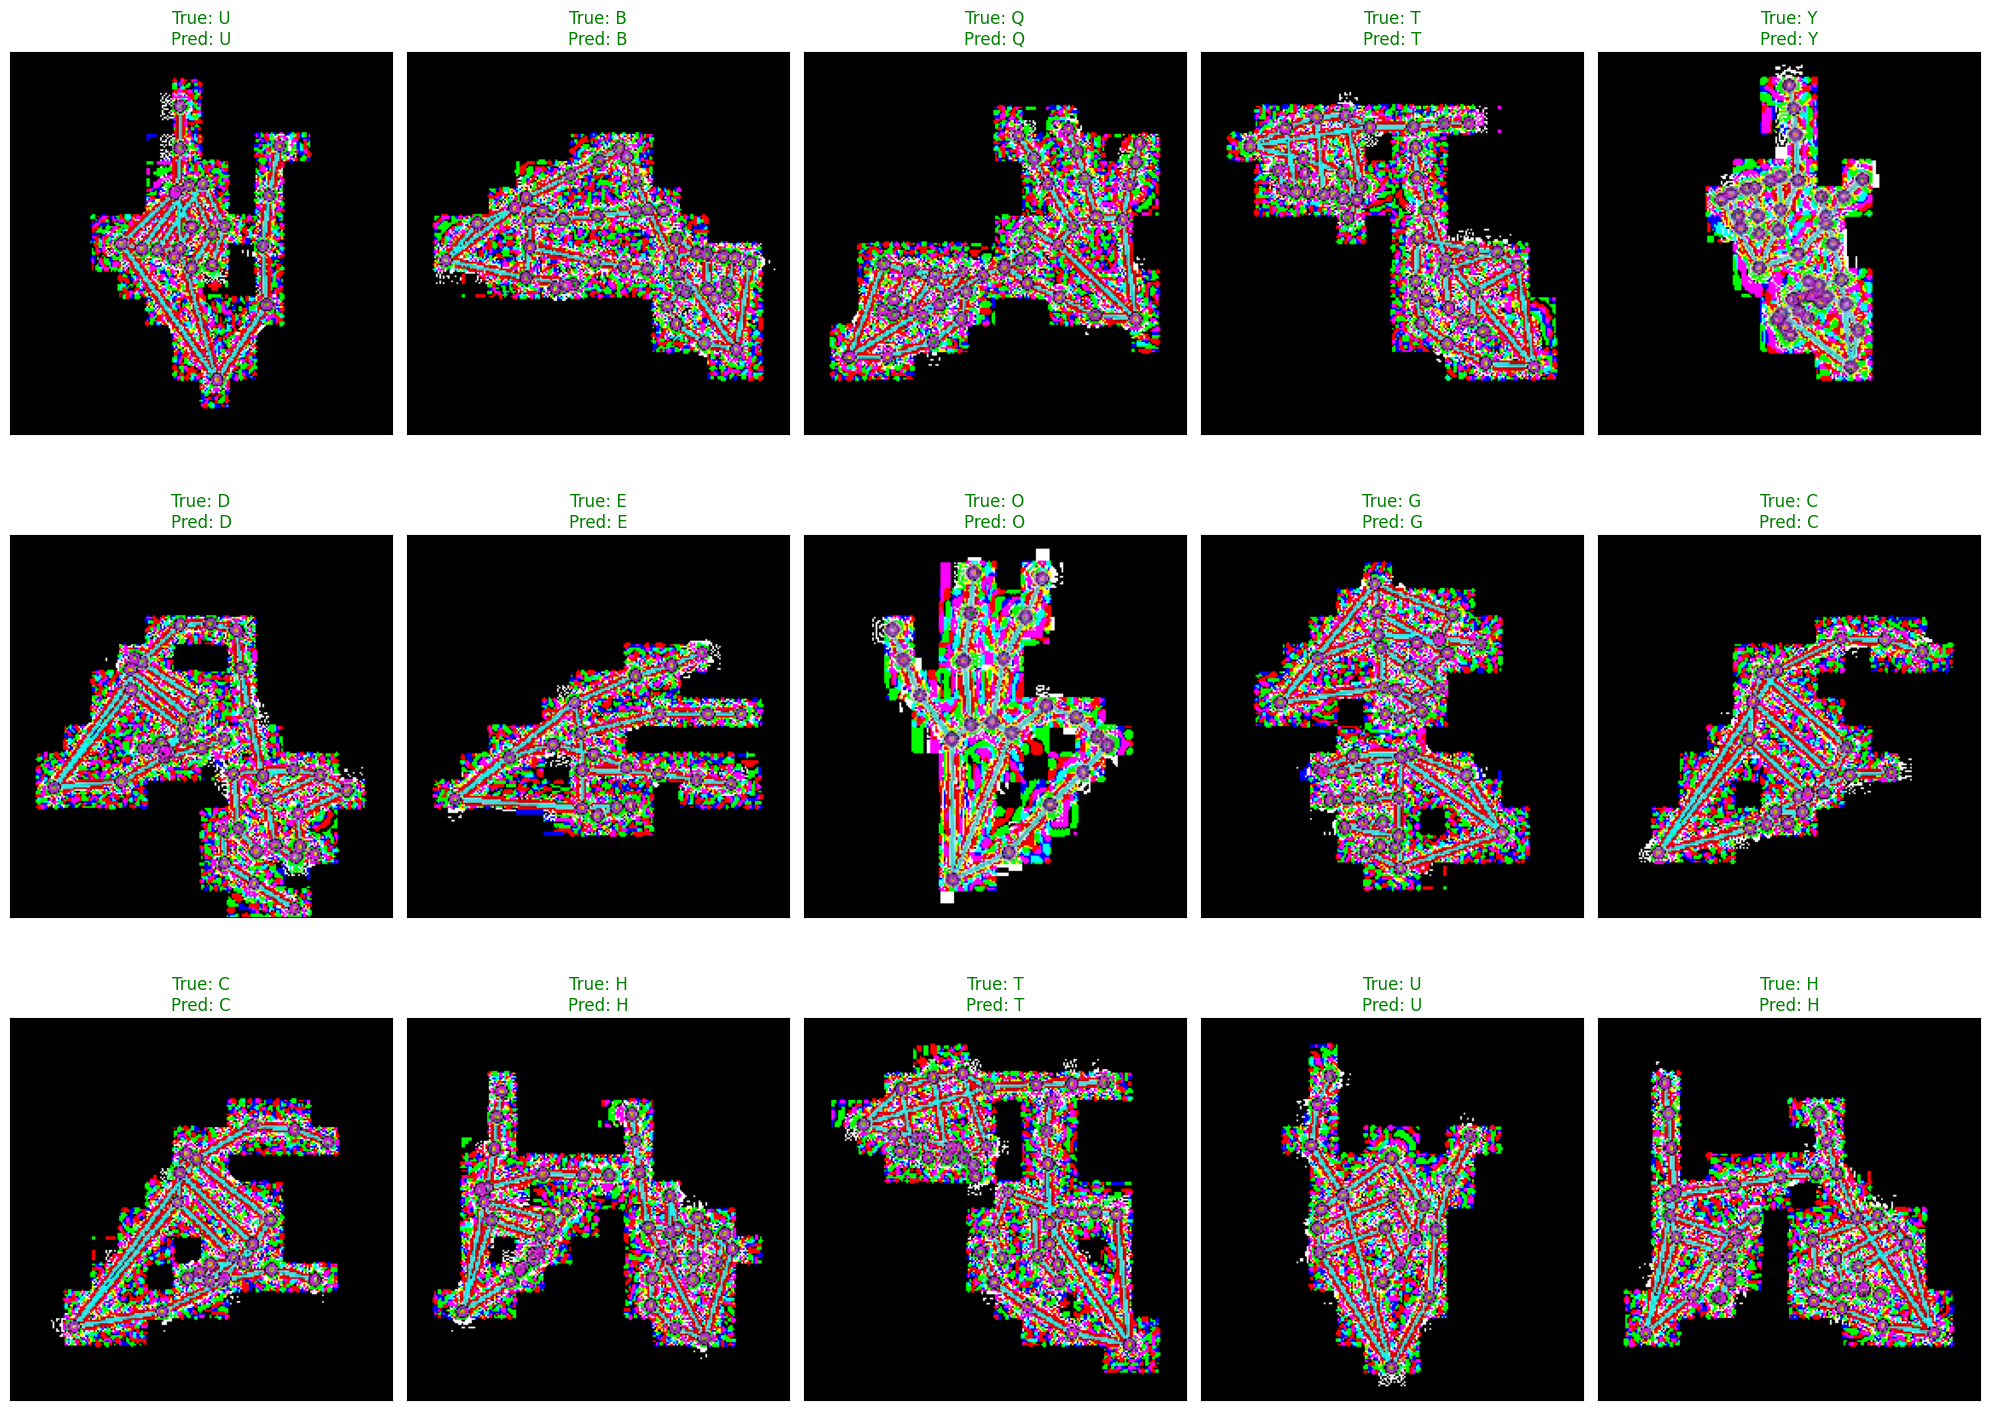

In [27]:
# Lakukan prediksi
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Tampilkan gambar
num_display = 15
random_indices = np.random.choice(len(X_test), size=num_display, replace=True)

nrows, ncols = 3, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15), subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flat

for i, ax in enumerate(axes):
    if i < num_display:
        idx = random_indices[i]
        
        # Konversi gambar ke uint8 untuk ditampilkan
        img_uint8 = (X_test[idx] * 255).astype(np.uint8)
        ax.imshow(img_uint8)

        true_label = class_names[np.argmax(y_test[idx])]
        predicted_label = class_names[y_pred_classes[idx]]
        color = 'green' if true_label == predicted_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

✅ Label dimuat: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
✅ Model berhasil dimuat.

🔍 Total gambar ditemukan: 26
📁 Folder uji: /kaggle/input/datasetujisegment/UJISEGMEN


/tmp/ipykernel_35/3477149051.py:74: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_35/3477149051.py:74: UserWarning: Glyph 128247 (\N{CAMERA}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128247 (\N{CAMERA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


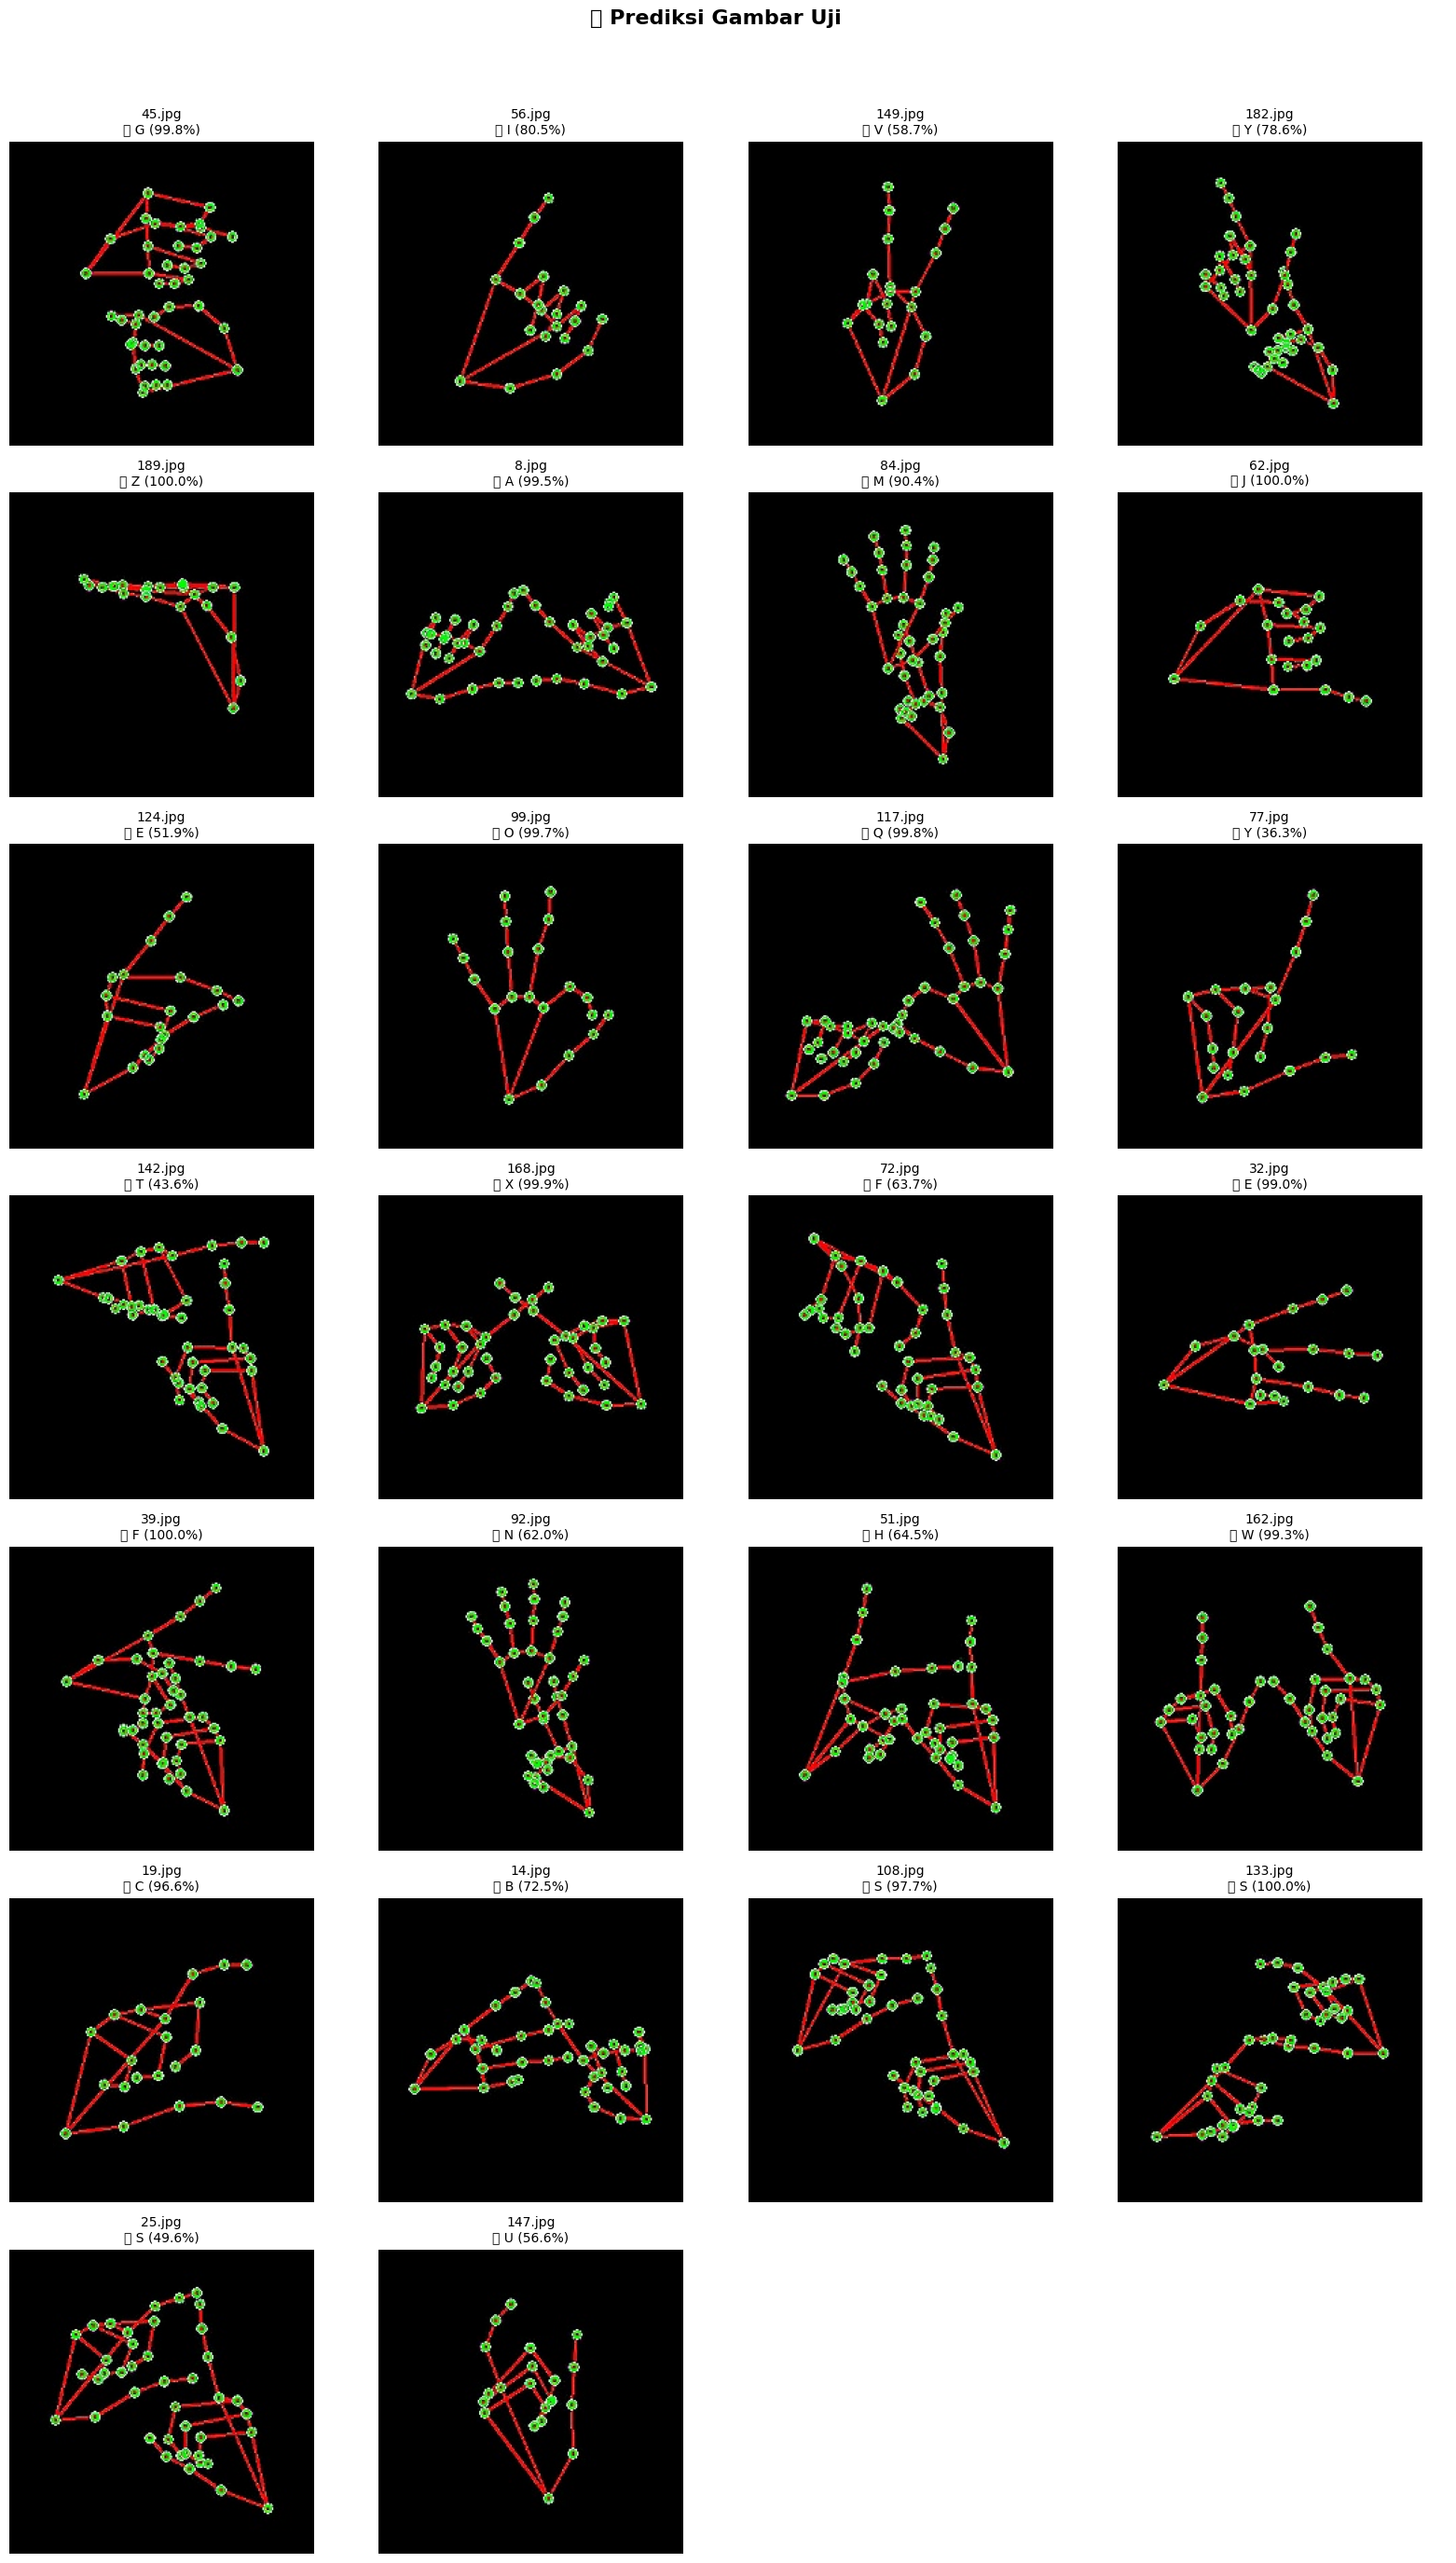


📊 Total gambar diuji: 26


In [28]:
import os
import json
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import img_to_array
import numpy as np
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input

# --- Konstanta ---
TEST_FOLDER = "/kaggle/input/datasetujisegment/UJISEGMEN"  # Semua gambar di satu folder
MODEL_PATH = "/kaggle/working/mobilenetv3.keras"
LABEL_MAP_PATH = "/kaggle/working/label_map.json"
IMG_SIZE = 224

# --- Load label_map.json ---
with open(LABEL_MAP_PATH, "r") as f:
    label_map = json.load(f)

# Ubah label_map dari dict string-key ke list dengan urutan index
# Misal: { "0": "A", "1": "B" } → ["A", "B"]
class_names = [label_map[str(i)] for i in range(len(label_map))]
print(f"✅ Label dimuat: {class_names}")

# --- Load model ---
model = load_model(MODEL_PATH)
print("✅ Model berhasil dimuat.")

# --- Fungsi prediksi ---
def predict_image(image_path):
    pil_img = Image.open(image_path).convert('RGB')
    pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BICUBIC)
    img_array = img_to_array(pil_img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array, verbose=0)
    class_index = np.argmax(prediction)
    confidence = np.max(prediction)
    
    return class_names[class_index], confidence, pil_img

# --- Ambil semua gambar dari folder uji ---
image_paths = [os.path.join(TEST_FOLDER, f)
               for f in os.listdir(TEST_FOLDER)
               if f.lower().endswith(('.jpg', '.png'))]

print(f"\n🔍 Total gambar ditemukan: {len(image_paths)}")
print(f"📁 Folder uji: {TEST_FOLDER}")

# --- Visualisasi hasil prediksi ---
if not image_paths:
    print("🚫 Tidak ditemukan gambar di folder uji.")
else:
    cols = 4
    rows = math.ceil(len(image_paths) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for i, img_path in enumerate(image_paths):
        predicted_class, conf, processed_img = predict_image(img_path)
        axes[i].imshow(processed_img)
        axes[i].set_title(f"{os.path.basename(img_path)}\n🧠 {predicted_class} ({conf*100:.1f}%)", fontsize=10)
        axes[i].axis('off')
        for spine in axes[i].spines.values():
            spine.set_visible(False)

    # Sembunyikan subplot kosong jika ada
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle("📷 Prediksi Gambar Uji", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print(f"\n📊 Total gambar diuji: {len(image_paths)}")


In [29]:
# Saat training:
np.save("class_names.npy", class_names)

# Saat prediksi:
class_names = np.load("class_names.npy")

In [30]:
import json

# Simpan label map ke file
label_map = {str(i): label for i, label in enumerate(class_names)}

with open("/kaggle/working/label_map.json", "w") as f:
    json.dump(label_map, f)

print("✅ label_map.json berhasil disimpan.")

✅ label_map.json berhasil disimpan.
